In [1]:
import os
from typing import Any

from PIL import Image
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torchvision.datasets import CocoDetection
from torch.utils.data.dataloader import DataLoader

In [2]:
class CocoAutoEncoderDataset(Dataset):
    def __init__(self, split : str = 'train', transform=None) -> None:
        super().__init__()
        self.files_path = f'../coco/images/{split}2017/'
        # self.ann_file = f'../coco/annotations/instances_{split}2017.json'

        self.inputs = os.listdir(self.files_path)[:1000]

        self.transform = transform# transforms.Compose([transforms.ToTensor()])

    def _load_image(self, path: str) -> Image.Image:
        return Image.open(path).convert("RGB")

    def __len__(self) -> int:
        return len(self.inputs)
    
    def __getitem__(self, index) -> Any:
        image = self._load_image(self.files_path + self.inputs[index])

        if self.transform is not None:
            image = self.transform(image)
        return image, image

In [3]:
dataset = CocoAutoEncoderDataset('train', transforms.Compose([transforms.ToTensor(), transforms.Resize((480, 640))]))
loader = DataLoader(dataset, batch_size=1)

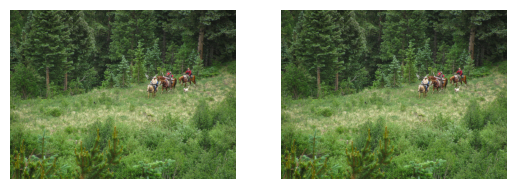

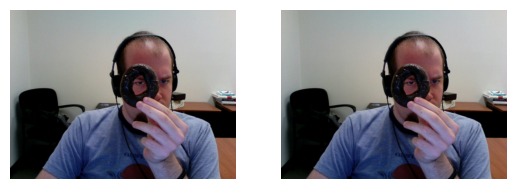

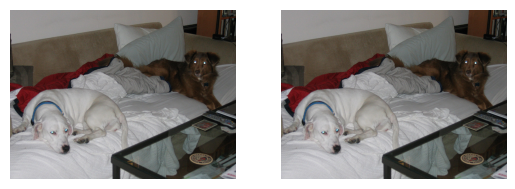

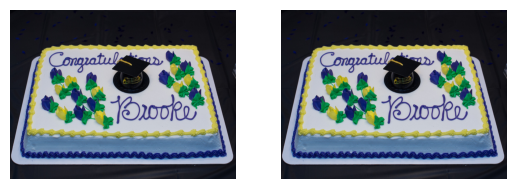

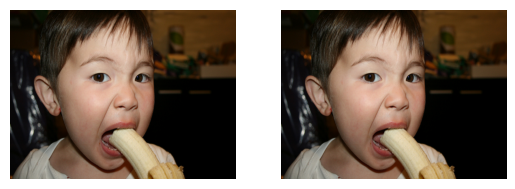

In [4]:
for x in range(len(dataset))[:5]:
    image, target = dataset[x]
    image = transforms.functional.to_pil_image(image)
    target = transforms.functional.to_pil_image(target)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(image)
    ax2.imshow(target)
    ax1.axis('OFF')
    ax2.axis('OFF')

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )


    def forward(self, x : torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
dataset_train = CocoAutoEncoderDataset('train', transforms.Compose([transforms.ToTensor(), transforms.Resize((480, 640))]))
loader_train = DataLoader(dataset, batch_size=16)

dataset_valid = CocoAutoEncoderDataset('val', transforms.Compose([transforms.ToTensor(), transforms.Resize((480, 640))]))
loader_valid = DataLoader(dataset_valid, batch_size=16)

dataset_test = CocoAutoEncoderDataset('test', transforms.Compose([transforms.ToTensor(), transforms.Resize((480, 640))]))
loader_test = DataLoader(dataset_test, batch_size=1)

In [52]:
EPOCHS = 120
LR = 1e-3

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [54]:
from copy import deepcopy
import numpy as np

best_model = None
best_loss = np.inf

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    valid_loss = 0
    for image, target in loader:
        image = image.to(device)
        target = target.to(device)

        output = model(image)
        # print(output.shape)
        # print(target.shape)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        for image, target in loader_valid:
            image = image.to(device)
            target = target.to(device)
                    
            output = model(image)
            loss = criterion(output, target)

            valid_loss += loss.item()

    if valid_loss < best_loss:
        best_model = deepcopy(model)
        best_loss = loss

    print(f"{epoch+1}/{EPOCHS}: train loss: {train_loss:.5f}, valid loss {valid_loss:.5f}.")

1/120: train loss: 16.441342251433525, valid loss 0.3545830629300326.
2/120: train loss: 5.28444203309482, valid loss 0.3005382660776377.
3/120: train loss: 4.5226313707535155, valid loss 0.25789380073547363.
4/120: train loss: 3.790573522564955, valid loss 0.22773627983406186.
5/120: train loss: 3.419521370786242, valid loss 0.21723266784101725.
6/120: train loss: 3.2484770256269258, valid loss 0.20960726286284626.
7/120: train loss: 3.1220784640754573, valid loss 0.20414415909908712.
8/120: train loss: 3.0170937453513034, valid loss 0.1981548590119928.
9/120: train loss: 2.950470030453289, valid loss 0.19575219578109682.
10/120: train loss: 2.8799916918796953, valid loss 0.19219795055687428.
11/120: train loss: 2.8341660675941966, valid loss 0.18757909745909274.
12/120: train loss: 2.781194704788504, valid loss 0.1783552502747625.
13/120: train loss: 2.744297477096552, valid loss 0.17832271265797317.
14/120: train loss: 2.717065639444627, valid loss 0.17978450830560178.
15/120: train

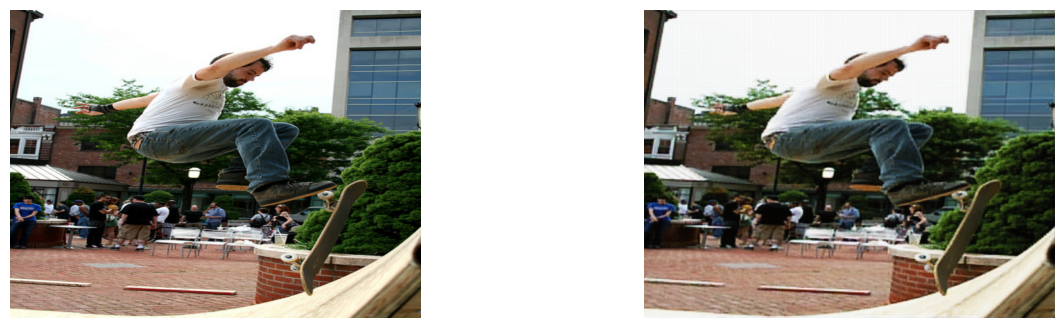

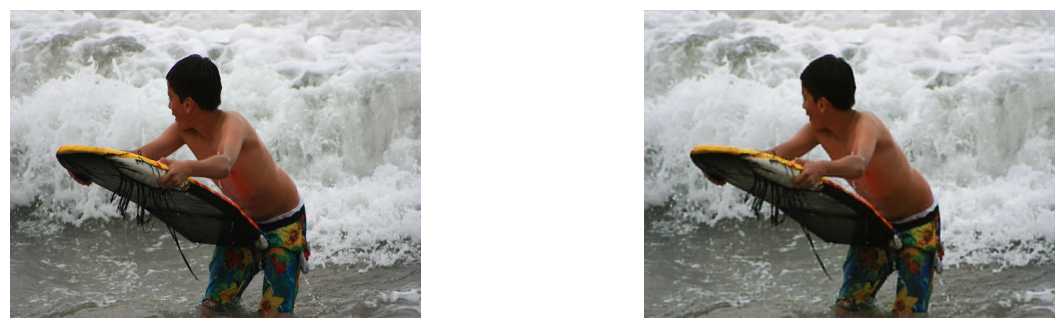

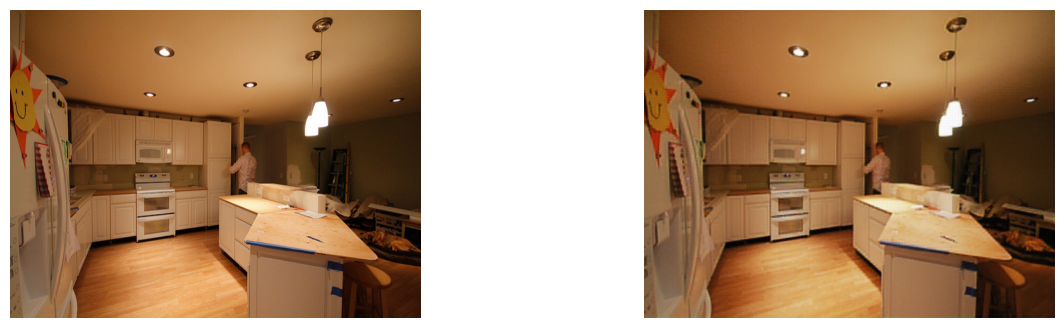

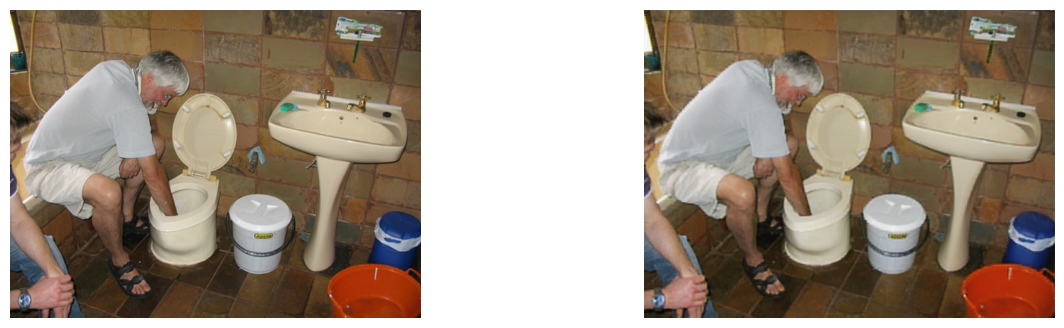

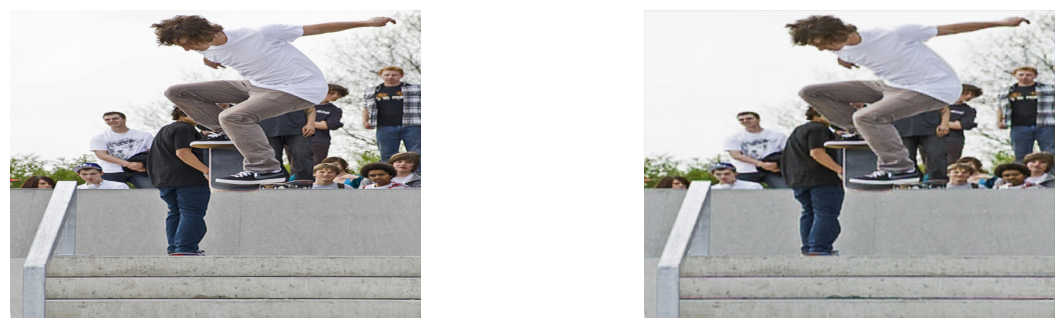

In [56]:
iterator = iter(loader_test)

for x in range(len(dataset_test))[:5]:
    image, _ = next(iterator)
    # target = transforms.functional.to_pil_image(target)
    output = model(image.to(device))
    # print(output.shape)
    image = transforms.functional.to_pil_image(image.squeeze(0).cpu())
    output = transforms.functional.to_pil_image(output.squeeze(0).cpu())

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 4))
    ax1.imshow(image)
    ax2.imshow(output)
    ax1.axis('OFF')
    ax2.axis('OFF')

In [57]:
torch.save(best_model.state_dict(), 'autoencoder.pt')

/tmp/ipykernel_18064/3860263151.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('autoencoder.pt'))


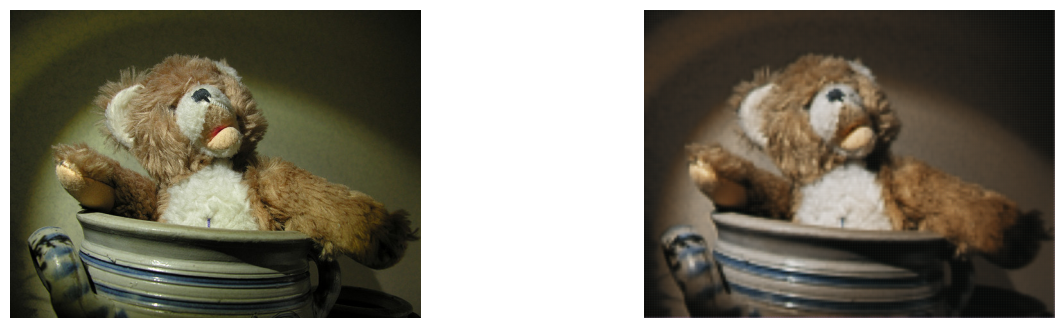

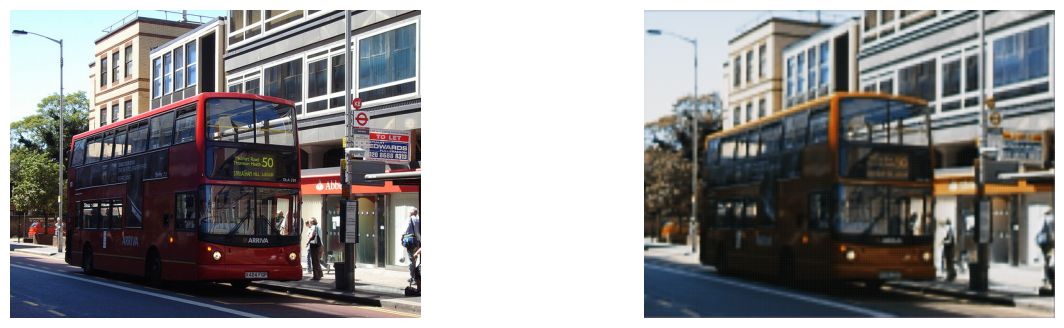

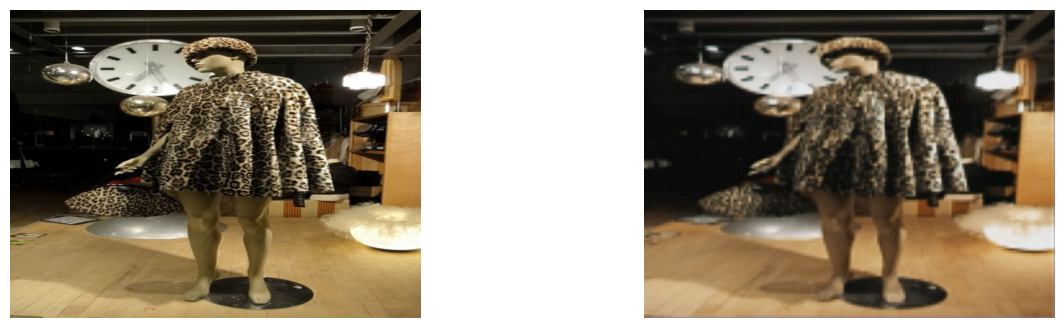

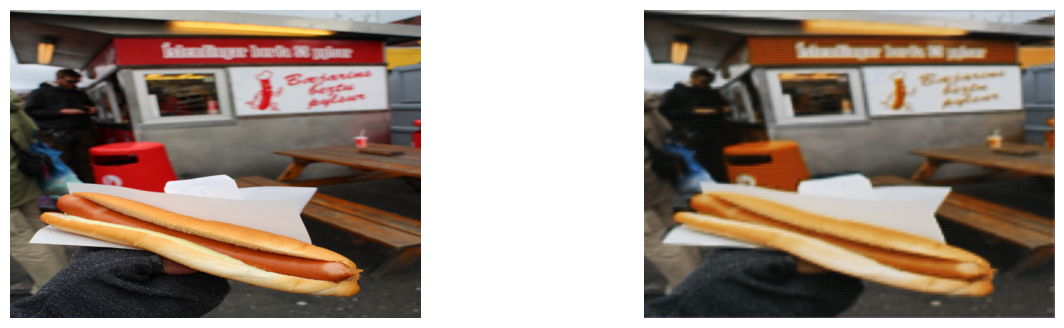

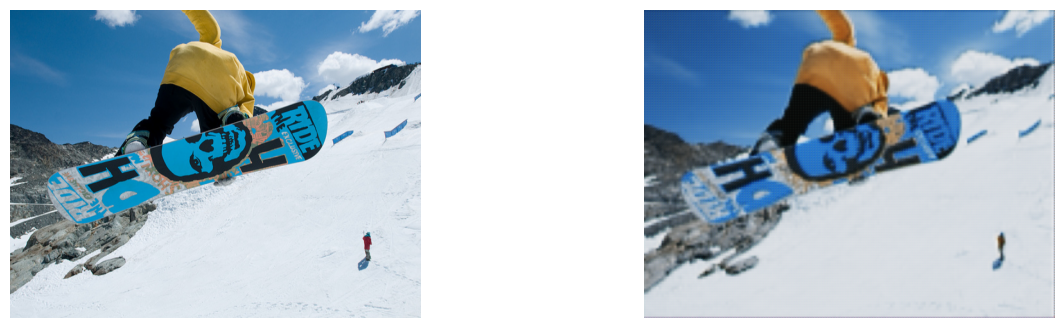

In [58]:
model.load_state_dict(torch.load('autoencoder.pt'))

for x in range(len(dataset_test))[:5]:
    image, _ = next(iterator)
    # target = transforms.functional.to_pil_image(target)
    output = best_model(image.to(device))
    # print(output.shape)
    image = transforms.functional.to_pil_image(image.squeeze(0).cpu())
    output = transforms.functional.to_pil_image(output.squeeze(0).cpu())

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 4))
    ax1.imshow(image)
    ax2.imshow(output)
    ax1.axis('OFF')
    ax2.axis('OFF')